In [1209]:
import pandas as pd
from scipy.stats import normaltest
import matplotlib.pyplot as plt
from time import time
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
import seaborn as sns
import numpy as np
from fastcore.parallel import *

In [1210]:
# чтение CSV-файла и создание DataFrame
train_df = pd.read_csv("train.csv", index_col=0)

# присоединение из изначальных данных строке, где "stroke = 1"
origin_df = pd.read_csv("healthcare-dataset-stroke-data.csv", index_col=0)
origin_df = origin_df.dropna()
origin_df = origin_df[origin_df['stroke'] == 1]
print(len(train_df))
train_df = pd.concat([train_df, origin_df])
print(len(train_df))

# перемешивание данных
idx = np.random.RandomState(seed=42).permutation(len(train_df))
train_df = train_df.iloc[idx].reset_index(drop=True)
train_df

15304
15513


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Female,44.00,0,0,Yes,Govt_job,Urban,87.95,26.3,Unknown,0
1,Female,75.00,0,0,Yes,Self-employed,Urban,78.16,34.5,never smoked,1
2,Female,23.00,0,0,No,Private,Urban,82.64,41.8,never smoked,0
3,Male,0.56,0,0,No,children,Rural,56.33,14.1,Unknown,0
4,Male,44.00,0,0,Yes,Private,Rural,56.11,27.6,never smoked,0
...,...,...,...,...,...,...,...,...,...,...,...
15508,Male,45.00,0,0,Yes,Govt_job,Urban,120.56,31.6,never smoked,0
15509,Male,56.00,0,0,Yes,Self-employed,Urban,76.51,28.4,never smoked,0
15510,Female,31.00,0,0,Yes,Private,Rural,82.57,30.7,smokes,0
15511,Female,53.00,0,0,Yes,Govt_job,Urban,68.68,31.1,smokes,0


## Исследование данных

In [1211]:
train_df.isnull().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [1212]:
# fig, axes = plt.subplots(7, 2, figsize = (20, 20))
# fig.subplots_adjust(hspace=0.5)

# ax = sns.countplot(ax=axes[0, 0], x = "gender", data = train_df[train_df.stroke == 0], order=['Male', 'Female', 'Others'])
# ax.set_title('Гендерное соотношение среди "stroke = 0"')
# ax = sns.countplot(ax=axes[0, 1], x = "gender", data = train_df[train_df.stroke == 1], order=['Male', 'Female'])
# ax.set_title('Гендерное соотношение среди "stroke = 1"')

# ax = sns.countplot(ax=axes[1, 0], x = "ever_married", data = train_df[train_df.stroke == 0])
# ax.set_title('Соотношение женатых среди "stroke = 0"')
# ax = sns.countplot(ax=axes[1, 1], x = "ever_married", data = train_df[train_df.stroke == 1])
# ax.set_title('Соотношение женатых среди "stroke = 1"')

# ax = sns.countplot(ax=axes[2, 0], x = "work_type", data = train_df[train_df.stroke == 0])
# ax.set_title('Соотношение профессий среди "stroke = 0"')
# ax = sns.countplot(ax=axes[2, 1], x = "work_type", data = train_df[train_df.stroke == 1])
# ax.set_title('Соотношение профессий среди "stroke = 1"')

# ax = sns.countplot(ax=axes[3, 0], x = "smoking_status", data = train_df[train_df.stroke == 0])
# ax.set_title('Соотношение курящих "stroke = 0"')
# ax = sns.countplot(ax=axes[3, 1], x = "smoking_status", data = train_df[train_df.stroke == 1])
# ax.set_title('Соотношение курящих "stroke = 1"')

# ax = sns.countplot(ax=axes[4, 0], x = "hypertension", data = train_df[train_df.stroke == 0])
# ax.set_title('Соотношение больных гипертонией среди "stroke = 0"')
# ax = sns.countplot(ax=axes[4, 1], x = "hypertension", data = train_df[train_df.stroke == 1])
# ax.set_title('Соотношение больных гипертонией среди "stroke = 1"')

# ax = sns.countplot(ax=axes[5, 0], x = "heart_disease", data = train_df[train_df.stroke == 0])
# ax.set_title('Соотношение людей с болезнью сердца среди "stroke = 0"')
# ax = sns.countplot(ax=axes[5, 1], x = "heart_disease", data = train_df[train_df.stroke == 1])
# ax.set_title('Соотношение людей с болезнью сердца "stroke = 1"')

# ax = sns.countplot(ax=axes[6, 0], x = "Residence_type", data = train_df[train_df.stroke == 0])
# ax.set_title('Соотношение места проживания среди "stroke = 0"')
# ax = sns.countplot(ax=axes[6, 1], x = "Residence_type", data = train_df[train_df.stroke == 1])
# ax.set_title('Соотношение места проживания сердца "stroke = 1"')

Из данных выше видно следующее влиянеие на целевую фичу:
1. Гендер слабо влияет
2. Не женатые значительно чаще страдают от инсульта
3. Люди с провессией "Children" почти не подвержены инсультам
4. Никогда не курившие люди режеподвержаны инсультам
5. Больные гипертонией чаще страдают от инсульта
6. Люди с болезнью сердца незначительно чаще страдают от инсульта

С учётом того, что в выборке количество людей с инсультом кратно меньше людей без (видно на графике ниже), то на таких малых значениях данные должны существенно скакать, из-за чего незначительные отклонения (как у гендера и болезнью сердца) могут быть вызваны скорей этими скачками, чем корелляцией

Соотношение:  841 к 14672


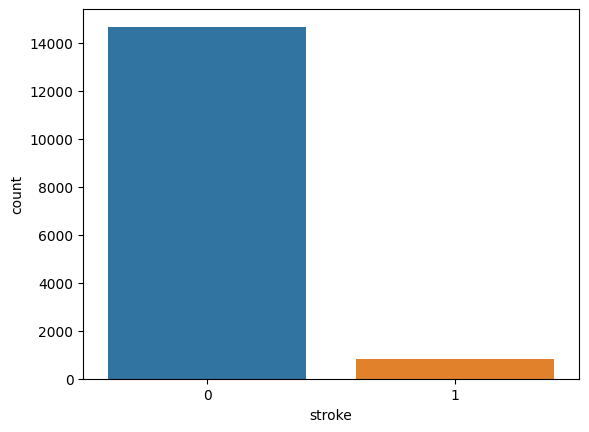

In [1213]:
sns.countplot(x = "stroke", data = train_df)
print("Соотношение: ", len(train_df[train_df.stroke == 1]), "к", len(train_df[train_df.stroke == 0]))

In [1214]:
# fig, axes = plt.subplots(1, 3, figsize = (20, 6))

# sns.scatterplot(ax = axes[0], x = 'avg_glucose_level', y = 'bmi', data = train_df, hue='stroke')
# sns.scatterplot(ax = axes[1], x = 'avg_glucose_level', y = 'age', data = train_df, hue = 'stroke')
# sns.scatterplot(ax = axes[2], x = 'bmi', y = 'age', data = train_df, hue = 'stroke')

Из графиков выше видно:
1. В первую очередь на вероятность инсульта влияет возраст
1. Уровень глюкозы также коллерирует с частотой возникновения инсульта
2. Не видно коллеряции индекса массы тела с инсультами

In [1215]:
# fig, axs = plt.subplots(2, 4, figsize=(15, 8))

# # Loop through each categorical feature and create a countplot on the corresponding subplot
# for i, feat in enumerate([
#     "gender",
#     "ever_married",
#     "work_type",
#     "Residence_type",
#     "smoking_status",
#     "glucose_levels",
# ]):
#     # Calculate the row and column indices for the subplot
#     row_idx, col_idx = divmod(i, 4)
    
#     # Create a countplot on the current subplot
#     sns.countplot(x=feat, data=train_df, palette='Set2', edgecolor='black', ax=axs[row_idx, col_idx])

#     # Set the title for the current subplot
#     axs[row_idx, col_idx].set_title(feat, size=18, y=1.03, fontname='Calibri',
#                                     fontweight='bold', color='#444444')
    
#     # rotate the class labels
#     axs[row_idx, col_idx].set_xticklabels(axs[row_idx, col_idx].get_xticklabels(), rotation=45)

# # hide last empty plot
# fig.delaxes(axs[1][3])


# # Add some padding between subplots
# plt.tight_layout()

# # Show the plot
# plt.show()

## Обработка данных

In [1216]:
# Преобразуем гендер, статус замужества в числовое значение
def transformData(train_df):
    train_df['never_smoked'] = train_df.apply(lambda row: 1 if row[9] == 'never smoked' else 0, axis=1)
    train_df_clean = train_df.replace({'gender': {'Male': 0, 'Other': 0.5, 'Female': 1}})
    train_df_clean = train_df_clean.replace({'ever_married': {'Yes': 1, 'No': 0}})
    dummies = pd.get_dummies(train_df['work_type'], dtype=int)
    train_df_clean = train_df_clean.drop('work_type', axis=1)
    train_df_clean = pd.concat([train_df_clean, dummies], axis=1)
    train_df_clean = train_df_clean.replace({'Residence_type': {'Urban': 1, 'Rural': 0}})
    train_df_clean = train_df_clean.replace({'smoking_status': {'never smoked': 0, 'Unknown': 0.33, 'formerly smoked': 0.66, 'smokes': 1}})
    return train_df_clean

train_df_clean = transformData(train_df)
train_df_clean

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,never_smoked,Govt_job,Never_worked,Private,Self-employed,children
0,1.0,44.00,0,0,1,1,87.95,26.3,0.33,0,0,1,0,0,0,0
1,1.0,75.00,0,0,1,1,78.16,34.5,0.00,1,1,0,0,0,1,0
2,1.0,23.00,0,0,0,1,82.64,41.8,0.00,0,1,0,0,1,0,0
3,0.0,0.56,0,0,0,0,56.33,14.1,0.33,0,0,0,0,0,0,1
4,0.0,44.00,0,0,1,0,56.11,27.6,0.00,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15508,0.0,45.00,0,0,1,1,120.56,31.6,0.00,0,1,1,0,0,0,0
15509,0.0,56.00,0,0,1,1,76.51,28.4,0.00,0,1,0,0,0,1,0
15510,1.0,31.00,0,0,1,0,82.57,30.7,1.00,0,0,0,0,1,0,0
15511,1.0,53.00,0,0,1,1,68.68,31.1,1.00,0,0,1,0,0,0,0


In [1217]:
# пробуем добавить новые фичи (спойлер: толку нет)
# train_df_clean['age/bmi'] = train_df_clean.age / train_df_clean.bmi
# train_df_clean['age*bmi'] = train_df_clean.age * train_df_clean.bmi
# train_df_clean['bmi/prime'] = train_df_clean.bmi / 25
# train_df_clean['obesity'] = train_df_clean.avg_glucose_level * train_df_clean.bmi / 1000
# train_df_clean['blood_heart']= train_df_clean.hypertension*train_df_clean.heart_disease

<function matplotlib.pyplot.show(close=None, block=None)>

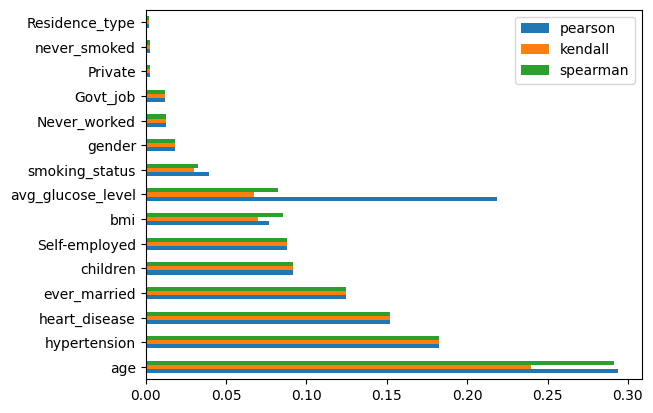

In [1218]:
cpearson_corr = pd.Series.abs(train_df_clean.corr(method='pearson')['stroke']) # корреляция по методу Пирсона
kendall_corr = pd.Series.abs(train_df_clean.corr(method='kendall')['stroke']) # корреляция по методу Кендалла
spearman_corr = pd.Series.abs(train_df_clean.corr(method='spearman')['stroke']) # корреляция по методу Спирмена
corr_result = pd.concat([cpearson_corr, kendall_corr, spearman_corr], keys=['pearson', 'kendall', 'spearman'], axis=1)
corr_result = corr_result.sort_values(by='kendall', ascending=False)[1:]
corr_result

corr_result.plot.barh()
plt.show
# sns.barplot(x=corr_result, y=corr_result.index) # Create a bar plot to visualize the correlations
# plt.xlabel('Correlation with stroke') # Add a label to the x-axis of the plot
# plt.show()

In [1219]:
# Проверка на наличие нормального распределения
columns_new = []
values_new = []
for column in train_df_clean.columns :
    p_value_factor = normaltest(train_df_clean[column]).pvalue
    columns_new.append(column)
    if p_value_factor > 0.05:
        values_new.append("+")
    else:
        values_new.append("-")
result = pd.DataFrame({'Фича': columns_new, 'имеет нормальное распределение': values_new})
result
# Проверка показала, что все поля не имеют нормального распределения,
# следовательно мы можем использвать либо корреляцию по методу Кендалла, либо по методу Спирмена.
# При этом, на таблице выше видно, что методы Кендалла и Спирмена имеют одинаковую последовательност


,Фича,имеет нормальное распределение
0,gender,-
1,age,-
2,hypertension,-
3,heart_disease,-
4,ever_married,-
5,Residence_type,-
6,avg_glucose_level,-
7,bmi,-
8,smoking_status,-
9,stroke,-


In [1220]:
def filterFeatures(train_df_clean):
    kendall_corr = pd.Series.abs(train_df_clean.corr(method='kendall')['stroke']) # вот этого тут быть не должно
    features = kendall_corr[(kendall_corr > 0) | (kendall_corr == 1)]
    features.sort_values(ascending=False)[1:]
    features = features.drop(['smoking_status', "gender", 'bmi', 'Private', 'Self-employed', 'Residence_type', 'Never_worked', 'Govt_job'])
    return features

features = filterFeatures(train_df_clean)
features

age                  0.239788
hypertension         0.182460
heart_disease        0.152293
ever_married         0.124595
avg_glucose_level    0.067071
stroke               1.000000
never_smoked         0.002352
children             0.091450
Name: stroke, dtype: float64

In [1221]:
# избавление от незначащих фич
train_df_clean = train_df_clean.filter(features.index)
train_df_clean

,age,hypertension,heart_disease,ever_married,avg_glucose_level,stroke,never_smoked,children
0,44.00,0,0,1,87.95,0,0,0
1,75.00,0,0,1,78.16,1,1,0
2,23.00,0,0,0,82.64,0,1,0
3,0.56,0,0,0,56.33,0,0,1
4,44.00,0,0,1,56.11,0,1,0
...,...,...,...,...,...,...,...,...
15508,45.00,0,0,1,120.56,0,1,0
15509,56.00,0,0,1,76.51,0,1,0
15510,31.00,0,0,1,82.57,0,0,0
15511,53.00,0,0,1,68.68,0,0,0


In [1222]:
# избавление от выбросов (увеличивает точность, но снижает f1_score)
# from sklearn.cluster import DBSCAN
# dbscan = DBSCAN(eps=1.8, min_samples=4)
# labels = dbscan.fit_predict(train_df_clean)
# filtered_data = train_df_clean[labels != -1]
# print(len(train_df_clean))
# print(len(filtered_data))
# filtered_data
# train_df_clean = filtered_data

## Разделение dataFrame на тестовую и тренировочную выборки

In [1223]:
# Разделение данных на тестовую и тренировочную выборки (менее эффективен)
# test_length_border = int(len(train_df_clean_outlierless) * 0.8)
# test_df_clean_temp = train_df_clean_outlierless[test_length_border : ]
# train_df_clean_temp = train_df_clean_outlierless[ : test_length_border]

# from sklearn.model_selection import train_test_split
# x_train, x_test, y_train, y_test = train_test_split(train_df_clean.drop(columns='stroke'), train_df_clean.loc[:, ['stroke']], random_state=2,test_size=0.2)

# x_train = train_df_clean_temp.drop(columns='stroke')
# y_train = train_df_clean_temp['stroke']

# x_test = test_df_clean_temp.drop(columns='stroke')
# y_test = test_df_clean_temp['stroke']

In [1224]:
# Выделение тестовых данных
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=32)

all_featers = train_df_clean.drop(columns='stroke')
factor = train_df_clean['stroke']

for train_index, test_index in skf.split(all_featers, factor):
    x_train, x_test = all_featers.iloc[train_index], all_featers.iloc[test_index]
    y_train, y_test = factor.iloc[train_index], factor.iloc[test_index]
print(len(y_test), len(y_test[y_test == 1]))
print(len(y_train), len(y_train[y_train == 1]))

1551 84
13962 757


In [1225]:
# train_df_merged = pd.concat([x_train, y_train], axis=1)


# #### альтернатива для Smote (менее эффективная)
# print(len(train_df_merged[train_df_merged['stroke'] == 1]))
# train_minor = train_df_merged[(train_df_merged["stroke"] == 1)]
# train_major = train_df_merged[(train_df_merged["stroke"] == 0)]

# from sklearn.utils import resample, shuffle

# minor_upsampled = resample(train_minor, n_samples=int(len(train_minor)*1.7), random_state=77)

# train_df_merged = pd.concat([minor_upsampled, train_major], ignore_index=True)
# train_df_merged = shuffle(train_df_merged,random_state=7)
# print(len(train_df_merged[train_df_merged['stroke'] == 1]))

# x_train, y_train = train_df_merged.drop(columns='stroke'), train_df_merged['stroke']


 

In [1226]:
# from sklearn.manifold import TSNE
# import matplotlib.pyplot as plt
# tsne = TSNE(n_components=2, random_state=42)
# X_tsne = tsne.fit_transform(x_train)

# plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_train/2)
# plt.show()

In [1227]:
# выравнивание классов
import numpy as np

# # субдескретизация уменьшением элементов до k где stroke = 0
# k = 0.7
# random_state = 42
# zero_idx = np.array(y_train[y_train == 0].index)
# subset_idx = np.random.RandomState(random_state).choice(zero_idx, size=int(k*len(zero_idx)), replace=False)

# one_idx = np.array(y_train[y_train == 1].index)
# c = np.concatenate((subset_idx, one_idx), axis=0)
# print(len(x_train))
# x_train = x_train.loc[c].sort_index()
# y_train = y_train.loc[c].sort_index()
# print(len(x_train))

# передискретизация дублированием n раз элементов где stroke = 1
n = 0
for i in range(n) :
    x_train = np.concatenate((x_train, x_train.loc[one_idx]))
    y_train = np.concatenate((y_train, y_train.loc[one_idx]))
    print(len(x_train))
# не везде работает

# избавление от связей Томека (без импакта)
from imblearn.under_sampling import TomekLinks
tomek = TomekLinks()
print(len(x_train))
x_tomek, y_tomek = tomek.fit_resample(x_train, y_train)
x_train, y_train = x_tomek, y_tomek
print(len(x_tomek))

# сосредоточение к ближайшим соседям (долго думает)
# from imblearn.under_sampling import CondensedNearestNeighbour
# cnn = CondensedNearestNeighbour(random_state=42) 
# print(len(x_train))
# x_tomek, y_tomek = cnn.fit_resample(x_train, y_train)
# x_train, y_train = x_tomek, y_tomek
# print(len(x_tomek))

13962
13679


#### SMOTE

In [1228]:
# # генерация искусственных данных с помощью SMOTE
# smote = SMOTE(sampling_strategy=0.07, random_state=8765)
# x_train_smote, y_train_smote = smote.fit_resample(x_train, y_train)
# print(len(x_train_smote))
# print("теперь равно нулю: ", len(y_train_smote[y_train_smote==0]))
# print("изначально равно нулю: ", len(y_train[y_train==0]))
# print("теперь равно еденице: ", len(y_train_smote[y_train_smote==1]))
# print("изначально равно еденице: ", len(y_train[y_train==1]))
# x_train = x_train_smote
# y_train = y_train_smote

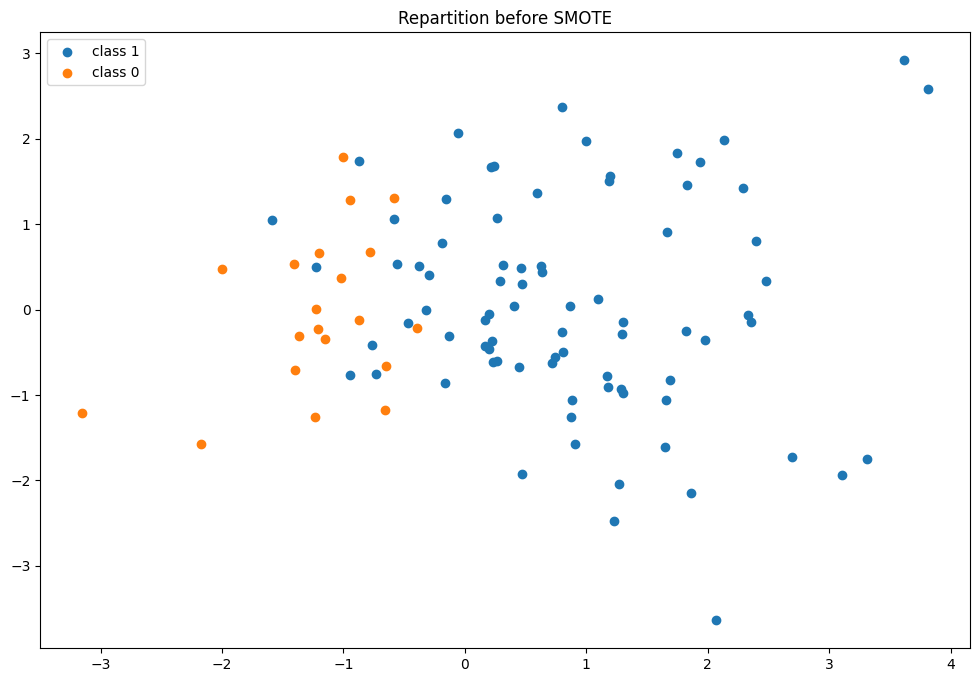

In [1229]:
# тесты
x_sample_train, y_sample_train = make_classification(n_samples=100, n_features=2,
                           n_informative=2, n_redundant=0,
                           n_classes=2, weights=[0.2, 0.8],
                           class_sep=0.95, random_state=0)

plt.figure(figsize=(12, 8))
plt.title('Repartition before SMOTE')
plt.scatter(x_sample_train[y_sample_train == 1][:, 0], x_sample_train[y_sample_train == 1][:, 1], label='class 1')
plt.scatter(x_sample_train[y_sample_train == 0][:, 0], x_sample_train[y_sample_train == 0][:, 1], label='class 0')
plt.legend()
plt.grid(False)
plt.show()

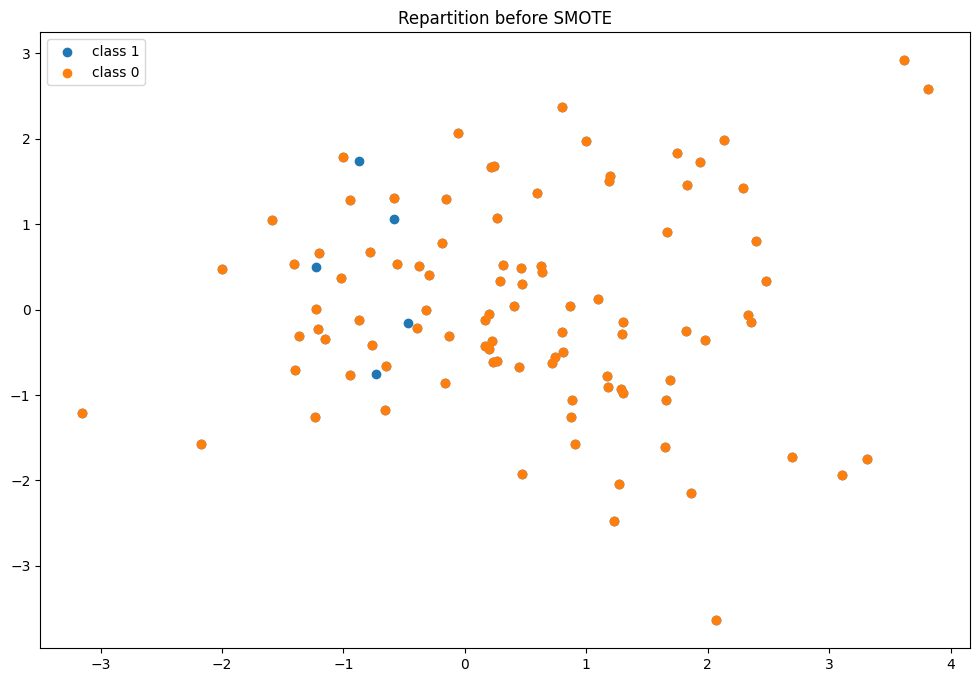

In [1230]:



# from sklearn.cluster import DBSCAN
# dbscan = DBSCAN(eps=0.5, min_samples=5)
# labels = dbscan.fit_predict(x_sample_train)
# filtered_data = x_sample_train[labels != -1]
# print(len(x_sample_train))
# print(len(filtered_data))

from imblearn.under_sampling import TomekLinks
tomek = TomekLinks()
X_tomek, y_tomek = tomek.fit_resample(x_sample_train, y_sample_train)


plt.figure(figsize=(12, 8))
plt.title('Repartition before SMOTE')
plt.scatter(x_sample_train[:, 0], x_sample_train[:, 1], label='class 1')
plt.scatter(X_tomek[:, 0], X_tomek[:, 1], label='class 0')
plt.legend()
plt.grid(False)
plt.show()

## Обучение моделей

In [1231]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn import metrics

def print_error_matrix(y_test, y_pred) :
    data = metrics.confusion_matrix(y_test, y_pred, labels=[0, 1])
    print(data)
    ax = sns.heatmap(data, annot=True, fmt="d")
    plt.title("Матрица ошибок", fontsize=12)
    plt.xlabel('predict') 
    plt.ylabel('test') 
    plt.show()

def print_metrics(y_test, y_pred) : 
    precision = precision_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print("Precision:", precision, "    Recall:", recall)
    print("Accuracy:", accuracy)
    print("F1:", f1)
    
def print_score(model, x_test) :
    score = roc_auc_score(y_test, model.predict_proba(x_test)[:, 1])
    print("Score:", score)


In [1232]:
y_predictions = []

In [1233]:
# naive bayes
from sklearn.naive_bayes import GaussianNB

# создаем объект модели
nb = GaussianNB()

nb.fit(x_train, y_train)

# делаем прогнозы на тестовой выборке
y_pred = nb.predict(x_test)

# оцениваем точность прогнозов
print_metrics(y_test, y_pred)
print_score(nb, x_test)
# naive bayes precision:  0.17777777777777778 predict_proba
# Accuracy: 0.9353152564521399
# Recall: 0.21621621621621623
# F1: 0.1951219512195122
# roc_auc:  0.5892945487860742


Precision: 0.2549019607843137     Recall: 0.4642857142857143
Accuracy: 0.8974854932301741
F1: 0.3291139240506329
Score: 0.8901872950952705


In [1234]:
from sklearn.linear_model import LogisticRegression

# создаем объект модели
lr_model = LogisticRegression(solver="newton-cg")

# обучаем модель на обучающей выборке
lr_model.fit(x_train, y_train)

# делаем прогнозы на тестовой выборке
y_pred = lr_model.predict(x_test)

# оцениваем точность прогнозов
print_metrics(y_test, y_pred)
print_score(lr_model, x_test)

# LogisticRegression precision:  0.3050847457627119
# Accuracy: 0.9562234563868017
# Recall: 0.16216216216216217
# F1: 0.21176470588235297
# roc_auc:  0.5741319285387083

Precision: 0.5217391304347826     Recall: 0.14285714285714285
Accuracy: 0.9464861379754996
F1: 0.2242990654205607
Score: 0.9122399130067841


In [1235]:
from sklearn.tree import DecisionTreeClassifier

# создаем объект модели
dt_model = DecisionTreeClassifier(random_state=42)

# обучаем модель на обучающей выборке
dt_model.fit(x_train, y_train)

# делаем прогнозы на тестовой выборке
y_pred = dt_model.predict(x_test)

# оцениваем точность прогнозов
print_metrics(y_test, y_pred)

print_score(dt_model, x_test)

# DecisionTreeClassifier precision:  0.19411764705882353
# Accuracy: 0.9297615158444953
# Recall: 0.2972972972972973
# F1: 0.23487544483985764

Precision: 0.23333333333333334     Recall: 0.3333333333333333
Accuracy: 0.9045776918117344
F1: 0.27450980392156865
Score: 0.6397612555588016


In [1236]:
from sklearn.ensemble import RandomForestClassifier

# создаем объект модели
rf_model = RandomForestClassifier(random_state=200, n_estimators=200)

# обучаем модель на обучающей выборке
rf_model.fit(x_train, y_train)

# делаем прогнозы на тестовой выборке
y_pred = rf_model.predict(x_test)

# оцениваем точность прогнозов
print_metrics(y_test, y_pred)
print_score(rf_model, x_test)
# DecisionTreeClassifier precision:  0.19411764705882353
# Accuracy: 0.9297615158444953
# Recall: 0.2972972972972973
# F1: 0.23487544483985764

Precision: 0.2891566265060241     Recall: 0.2857142857142857
Accuracy: 0.9232753062540296
F1: 0.2874251497005988
Score: 0.8509876002207292


In [1237]:
from lightgbm import LGBMClassifier

lgbm_hyperparameters = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2,],
    'num_leaves': [2, 6, 10, 14, 18, 20],
    'max_depth': [2, 6, 8,  12,  16,  20],
    'min_child_samples': [2, 4,  8, 12, 16,  20],
    'subsample': [0.5, 0.6, 0.8, 1],
}
# clf = LGBMClassifier(random_state=seed, n_jobs=-1)
# grid_search = GridSearchCV(clf, lgbm_hyperparameters, cv=5, n_jobs=-1, verbose=1)
# grid_search.fit(train_X, train_y)
# print(grid_search.best_params_)

lgbm_model = LGBMClassifier(random_state=200, n_estimators=100, learning_rate=0.18, max_depth=3, min_child_samples=17, num_leaves=6, n_jobs=-1)#(random_state=200, n_estimators=600, learning_rate=0.08, max_depth=3, min_child_samples=17, num_leaves=6, n_jobs=-1)
lgbm_model.fit(x_train, y_train)


# делаем прогнозы на тестовой выборке
y_pred = lgbm_model.predict(x_test)

y_predictions.append(lgbm_model.predict_proba(x_test)[:, 1])

# оцениваем точность прогнозов
print_metrics(y_test, y_pred)
print_score(lgbm_model, x_test)

# Precision: 0.48936170212765956     Recall: 0.32857142857142857
# Accuracy: 0.945046439628483
# F1: 0.39316239316239315
# Score: 0.8896188917465514



fi = pd.DataFrame({
    'cols': x_train.columns,
    'imp': lgbm_model.feature_importances_
}).sort_values('imp', ascending=False)
fi


Precision: 0.5526315789473685     Recall: 0.25
Accuracy: 0.9484203739522888
F1: 0.3442622950819672
Score: 0.92138961924238


,cols,imp
4,avg_glucose_level,255
0,age,171
5,never_smoked,24
1,hypertension,18
3,ever_married,16
2,heart_disease,13
6,children,3


In [1270]:
from xgboost import XGBClassifier
# Создаем модель XGBClassifier
model_xgb = XGBClassifier(random_state=200, n_estimators=100, max_depth=1, colsample_bytree=0.8, subsample=0.47, eta=0.2)#(n_estimators=300, random_state=200, max_depth=2, colsample_bytree=0.8, subsample=0.61, eta=0.2)
# Обучаем модель на обучающей выборке
model_xgb.fit(x_train, y_train)

# Выполняем предсказание на тестовой выборке
y_pred = model_xgb.predict(x_test)

# Вычисляем метрики качества модели
print_metrics(y_test, y_pred)
print_score(model_xgb, x_test)
#y_predictios.append(model_xgb.predict_proba(x_test)[:, 1])

# Precision: 0.49056603773584906     Recall: 0.37142857142857144
# Accuracy: 0.945046439628483
# F1: 0.4227642276422764
# Score: 0.8853986439092822

Precision: 0.6129032258064516     Recall: 0.2261904761904762
Accuracy: 0.950354609929078
F1: 0.33043478260869563
Score: 0.9213165838932709


Precision: 0.5277777777777778     Recall: 0.2261904761904762
Accuracy: 0.9471308833010961
F1: 0.31666666666666665
Score: 0.922022592267991
[[1450   17]
 [  65   19]]


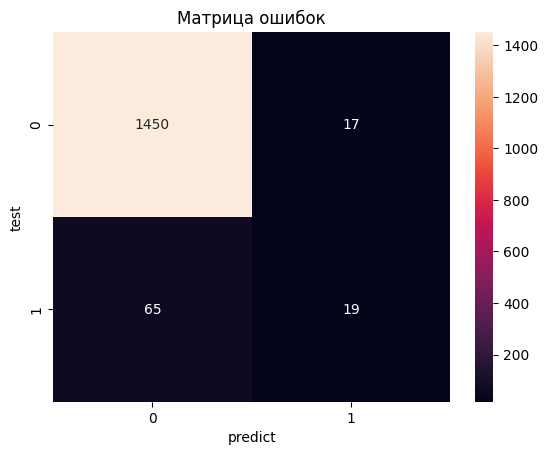

In [1239]:
from catboost import CatBoostClassifier

# Создаем модель CatBoostClassifier
model_cb = CatBoostClassifier(n_estimators=100, random_state=305, depth=4, logging_level='Silent', learning_rate=0.5, l2_leaf_reg=7, eval_metric='Accuracy')#(n_estimators=100, random_state=203, depth=7, logging_level='Silent', learning_rate=0.5, l2_leaf_reg=7, eval_metric='F1')
# Обучаем модель на обучающей выборке
model_cb.fit(x_train, y_train)

# Выполняем предсказание на тестовой выборке
y_pred = model_cb.predict(x_test)

print_metrics(y_test, y_pred)
print_score(model_cb, x_test)
print_error_matrix(y_test, y_pred) 

# y_predictions.append(model_cb.predict_proba(x_test)[:, 1])

# Precision: 0.4426229508196721     Recall: 0.38571428571428573
# Accuracy: 0.9404024767801857
# F1: 0.4122137404580153
# Score: 0.8835690904839841

In [1240]:
scores = []

def do_step(n):
    #n/=10
    model = LogisticRegression(random_state=n, solver="newton-cg")
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    scores.append([n, accuracy_score(y_test, y_pred), f1_score(y_test, y_pred)])
    print(n)

# parallel(do_step, list(range(1, 20, 1)), n_workers=8)

# scores = pd.DataFrame(scores)
# scores.set_index(0, inplace=True)
# print('Max: \n', scores[scores[2] == scores[2].max()])
# print('Mean: ', scores[1].mean(), " ", scores[2].mean())
# print('Median: ', scores[1].median(), " ", scores[2].median())
# scores

In [1241]:
scores = []

def do_step(n):
    #n/=10
    model_cb = CatBoostClassifier(n_estimators=100, random_state=n, depth=4, logging_level='Silent', learning_rate=0.5, l2_leaf_reg=7, eval_metric='Accuracy')
    model_cb.fit(x_train, y_train)
    y_pred = model_cb.predict(x_test)

    scores.append([n, accuracy_score(y_test, y_pred), f1_score(y_test, y_pred)])
    print(n)

# parallel(do_step, list(range(51, 1000, 50)), n_workers=8)

# scores = pd.DataFrame(scores)
# scores.set_index(0, inplace=True)
# print('Max: \n', scores[scores[1] == scores[1].max()])
# print('Mean: ', scores[1].mean(), " ", scores[2].mean())
# print('Median: ', scores[1].median(), " ", scores[2].median())
# scores

In [1242]:
scores = []

def do_step(n):
    #n/=100
    model = XGBClassifier(random_state=200, n_estimators=100, max_depth=1, colsample_bytree=0.8, subsample=0.47, eta=0.2)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    scores.append([n, accuracy_score(y_test, y_pred), f1_score(y_test, y_pred)])
    print(n)

# parallel(do_step, list(range(10, 300, 10)), n_workers=8)

# scores = pd.DataFrame(scores)
# scores.set_index(0, inplace=True)
# print('Max: \n', scores[scores[1] == scores[1].max()])
# print('Mean: ', scores[1].mean(), " ", scores[2].mean())
# print('Median: ', scores[1].median(), " ", scores[2].median())
# scores

In [1243]:
scores = []

def do_step(n):
    #n/=100
    model = LGBMClassifier(random_state=n, n_estimators=100, learning_rate=0.18, max_depth=3, min_child_samples=17, num_leaves=6, n_jobs=-1)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    scores.append([n, accuracy_score(y_test, y_pred), f1_score(y_test, y_pred)])
    print(n)

# parallel(do_step, list(range(200, 220, 1)), n_workers=8)

# scores = pd.DataFrame(scores)
# scores.set_index(0, inplace=True)
# print('Max: \n', scores[scores[2] == scores[2].max()])
# print('Mean: ', scores[1].mean(), " ", scores[2].mean())
# print('Median: ', scores[1].median(), " ", scores[2].median())
# scores

In [1244]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})"
                  .format(results['mean_test_score'][candidate],
                          results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

def run_arrange(param_grid, model) :
    grid_search = GridSearchCV(model, param_grid=param_grid, cv=4, n_jobs=-1, scoring='roc_auc', verbose=5 )
    start = time()
    grid_search.fit(x_train, y_train)

    print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
        % (time() - start, len(grid_search.cv_results_['params'])))
    report(grid_search.cv_results_)

# параметры
ct_param_grid = {'n_estimators': np.arange(50, 500, 50),
            'random_state': [203],
            'depth': [3],
            'learning_rate': [0.5],
            'l2_leaf_reg': [6],
            'eval_metric': ['Recall'] }

xgb_param_grid = {'n_estimators': np.arange(100, 800, 100),
            'random_state': [10],
            'max_depth': np.arange(1, 4, 1),
            'colsample_bytree': np.arange(0.3, 0.8, 0.1),
            'subsample': np.arange(0.1, 0.3, 0.05),
            'eta': np.arange(0.1, 0.3, 0.1) }

lgbm_param_grid = {'random_state': [200], 
                'n_estimators': np.arange(100, 1000, 100), 
                'learning_rate': np.arange(0.01, 0.1, 0.01), 
                'max_depth': [2,3,4], 
                'min_child_samples': np.arange(10, 20, 1), 
                'num_leaves': np.arange(3, 8, 1), 
                'n_jobs': [-1]
    
}
#n_estimators=100, random_state=10, max_depth=1, colsample_bytree=0.7, subsample=0.25, eta=0.2


#run_arrange(lgbm_param_grid, lgbm_model)

In [1245]:
# ансамбль моделей
y_predictions_proba = pd.DataFrame(y_predictions)
y_pred_proba = y_predictions_proba.sum() / len(y_predictions_proba)

print_metrics(y_test, y_pred_proba.map(lambda x: 0 if x < 0.5 else 1))

Precision: 0.5526315789473685     Recall: 0.25
Accuracy: 0.9484203739522888
F1: 0.3442622950819672


In [1246]:
for key,value in model_cb.get_all_params().items():
 print('{}, {}'.format(key,value))

nan_mode, Min
eval_metric, Accuracy
iterations, 100
sampling_frequency, PerTree
leaf_estimation_method, Newton
grow_policy, SymmetricTree
penalties_coefficient, 1
boosting_type, Plain
model_shrink_mode, Constant
feature_border_type, GreedyLogSum
bayesian_matrix_reg, 0.10000000149011612
eval_fraction, 0
force_unit_auto_pair_weights, False
l2_leaf_reg, 7
random_strength, 1
rsm, 1
boost_from_average, False
model_size_reg, 0.5
pool_metainfo_options, {'tags': {}}
subsample, 0.800000011920929
use_best_model, False
class_names, [0, 1]
random_seed, 305
depth, 4
posterior_sampling, False
border_count, 254
classes_count, 0
auto_class_weights, None
sparse_features_conflict_fraction, 0
leaf_estimation_backtracking, AnyImprovement
best_model_min_trees, 1
model_shrink_rate, 0
min_data_in_leaf, 1
loss_function, Logloss
learning_rate, 0.5
score_function, Cosine
task_type, CPU
leaf_estimation_iterations, 1
bootstrap_type, MVS
max_leaves, 16


In [1247]:
# scores = []

# def do_step(n):
#     #n = n/10

#     best_params_lgbm = {'n_estimators': 550, 'max_depth': 1, 'colsample_bytree': 0.8, 'subsample': 0.24, 'eta': 0.2}
#     lgbm_model = XGBClassifier(random_state=n, n_jobs=-1, **best_params_lgbm)
#     lgbm_model.fit(x_train, y_train)
#     y_pred = lgbm_model.predict(x_test)

#     scores.append([n, f1_score(y_test, y_pred)])
#     print(n)

# parallel(do_step, list(range(10, 40, 1)), n_workers=8)

# scores = pd.DataFrame(scores)
# scores.set_index(0, inplace=True)
# print('Max: \n', scores[scores[1] == scores[1].max()])
# print('Mean: ', scores[1].mean())
# scores

In [1248]:
test = [[1,2,3],[1,2,3]]
test2 = pd.DataFrame(test)
test2.set_index(1, inplace=True)
print(test2)

   0  2
1      
2  1  3
2  1  3


In [1249]:
fi = pd.DataFrame({
    'cols': x_train.columns,
    'imp': model_cb.feature_importances_
}).sort_values('imp', ascending=False)
fi

,cols,imp
0,age,69.137497
4,avg_glucose_level,17.094835
5,never_smoked,4.669697
1,hypertension,3.330373
3,ever_married,3.112924
2,heart_disease,2.624528
6,children,0.030145


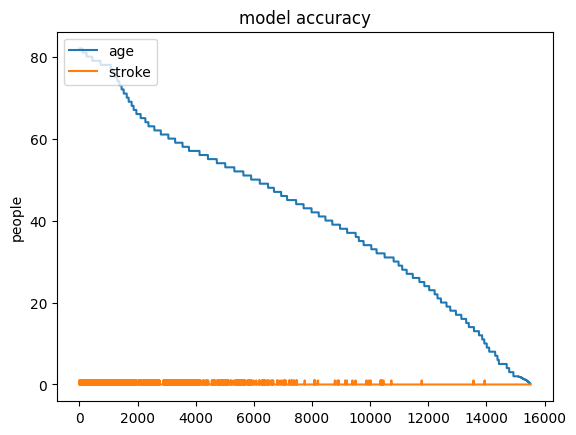

In [1250]:
import matplotlib.pyplot as plt

draw_dp = train_df.sort_values(by='age', ascending=False)
plt.plot(range(len(draw_dp)), draw_dp['age'], )
plt.plot(range(len(draw_dp)), draw_dp['stroke'])
plt.title('model accuracy')
plt.ylabel('people')
plt.legend(['age', 'stroke'], loc='upper left')
plt.show()

c:\Users\ilya1\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ilya1\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

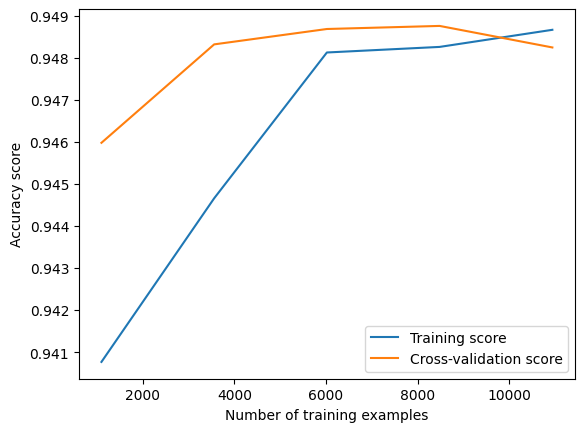

In [1251]:
from sklearn.model_selection import learning_curve
# Создадим объект LogisticRegression
logreg = LogisticRegression()

# Определим значения для тренировочных и проверочных данных
# В данном примере будем использовать 5 разбиений
train_sizes, train_scores, test_scores = learning_curve(logreg, x_train, y_train, cv=5)

# Вычислим средние значения по всем тренировочным и проверочным данным
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

# Создадим график
plt.plot(train_sizes, train_mean, label='Training score')
plt.plot(train_sizes, test_mean, label='Cross-validation score')
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy score')
plt.legend(loc='best')
plt.show()

# for i in y_train.values: 
#     print(y_train[12000:])

In [1252]:
# print("naive bayes precision: ", GaussianNBPrecision)
# print("LogisticRegression precision: ", LogisticRegressionPrecision)
# print("DecisionTreeClassifier precision: ", DecisionTreeClassifierPrecision)
# print("LGBMClassifier precision: ", LGBMClassifierPrecision)

# Предсказание результатов

In [1253]:
test_df = pd.read_csv("test.csv", index_col=0)

test_df_clean = transformData(test_df)
test_df_clean

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,smoking_status,never_smoked,Govt_job,Never_worked,Private,Self-employed,children
id,,,,,,,,,,,,,,,
15304,1.0,57.0,0,0,1,0,82.54,33.4,0.33,0,0,0,1,0,0
15305,0.0,70.0,1,0,1,1,72.06,28.5,0.33,0,0,0,1,0,0
15306,1.0,5.0,0,0,0,1,103.72,19.5,0.33,0,0,0,0,0,1
15307,1.0,56.0,0,0,1,1,69.24,41.4,1.00,0,1,0,0,0,0
15308,0.0,32.0,0,0,1,0,111.15,30.1,1.00,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25503,1.0,27.0,0,0,0,1,75.77,17.6,0.00,1,0,0,1,0,0
25504,0.0,49.0,0,0,1,1,102.91,26.7,0.33,0,0,0,1,0,0
25505,1.0,3.0,0,0,0,0,104.04,18.3,0.33,0,0,0,0,0,1


In [1254]:
# избавление от незначащих фич
test_df_clean = test_df_clean.filter(features.index)
test_df_clean

,age,hypertension,heart_disease,ever_married,avg_glucose_level,never_smoked,children
id,,,,,,,
15304,57.0,0,0,1,82.54,0,0
15305,70.0,1,0,1,72.06,0,0
15306,5.0,0,0,0,103.72,0,1
15307,56.0,0,0,1,69.24,0,0
15308,32.0,0,0,1,111.15,0,0
...,...,...,...,...,...,...,...
25503,27.0,0,0,0,75.77,1,0
25504,49.0,0,0,1,102.91,0,0
25505,3.0,0,0,0,104.04,0,1


In [1255]:
tomek = TomekLinks()
print(len(x_train))
x_train_all, y_train_all = tomek.fit_resample(all_featers, factor)

model_xgb = XGBClassifier(random_state=200, n_estimators=100, max_depth=1, colsample_bytree=0.8, subsample=0.47, eta=0.2)
model_xgb.fit(x_train_all, y_train_all)

13679


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eta=0.2, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=1,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [1256]:
y_predictions = []
#y_predictions.append(model_cb.predict_proba(test_df_clean)[:, 1])
#y_predictions.append(lgbm_model.predict_proba(test_df_clean)[:, 1])
y_predictions.append(model_xgb.predict_proba(test_df_clean)[:, 1]) # первый без него, второй только с ним

y_predictions_proba = pd.DataFrame(y_predictions)
y_pred_proba = y_predictions_proba.sum() / len(y_predictions_proba)

In [1257]:
#y_pred_proba = rf_model.predict_proba(test_df_clean)[:, 1]

submission = pd.DataFrame({
    "id" : test_df_clean.index,
    "stroke" : y_pred_proba,
})


submission.to_csv("our_result.csv", index=False)

testing = pd.read_csv("our_result.csv")
testing.head()

,id,stroke
0,15304,0.049377
1,15305,0.280681
2,15306,0.001574
3,15307,0.035826
4,15308,0.006273


In [1258]:
len(testing)

10204